### Price Path Simulator
1) Gather Data (Choose asset --> Daily end of day prices (Time Period))
2) Measure **Price Differences (+/-)** & **Price Returns (%)** over time
3) For both differences & returns, fit a **Bell Curve (Gaussian)**
4) Compare **Real Data** to the **Model** (using histogram / bar chart)
5) **Simulate** new price paths (Bachelier Model) & (Samuelson Model)
6) Show and Compare

In [89]:
import yfinance as yf 
from dotenv import load_dotenv
import os
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from scipy.stats import norm

load_dotenv()
API_KEY = os.getenv('API_KEY')

In [90]:
def load_data(ticker):
    url = f"https://backend.simfin.com/api/v3/companies/prices/compact?ticker={ticker}"
    headers = {
        "accept": "application/json",
        "authorization": API_KEY
    }

    response = requests.get(url, headers = headers).json()
    json_data = response[0]

    df = pd.DataFrame(json_data['data'], columns = json_data['columns'])
    df.to_csv(f'data/raw/{ticker}-price-data.csv', index = False)

def clean_data(ticker, raw_data):
    df = pd.read_csv(raw_data)
    df = df[['Date', 'Last Closing Price']]
    df['Date'] = pd.to_datetime(df['Date'])
    df.to_csv(f'data/processed/{ticker}-price-data.csv', index = False)

def enrich_data(ticker, processed_data):
    df = pd.read_csv(processed_data)
    df['price_diff'] = df['Last Closing Price'].diff()
    df['Returns'] = df['Last Closing Price'].pct_change()
    df = df.dropna()
    df.to_csv(f'data/enrich/{ticker}-price-data.csv', index = False)
    return df

def data_split(df, test_size=0.2):
    split_idx = int(len(df) * (1 - test_size))
    history_df = df[:split_idx]
    future_df = df[split_idx:]
    return history_df, future_df

def fit_gaussian(df):
    price_diffs = df['price_diff'].values
    returns = df['Returns'].values

    mean_diff, std_diff = norm.fit(price_diffs)
    mean_returns, std_returns = norm.fit(returns)
    return price_diffs, returns, mean_diff, std_diff, mean_returns, std_returns

def compare_gaussian(df):
    price_diffs, returns, mean_diff, std_diff, mean_returns, std_returns = fit_gaussian(df)

    print(f'Price Differences ~ N({mean_diff:.4f}, {std_diff:.4f}^2)')
    print(f'Returns ~ N({mean_returns:4f}, {std_returns:4f}^2)')
    plot_models(price_diffs, returns, mean_diff, std_diff, mean_returns, std_returns)

def plot_models(price_diffs, returns, mean_diff, std_diff, mean_returns, std_returns):
    plt.figure()
    plt.hist(price_diffs, bins = 50, density = True, alpha = 0.6, label = 'Price Differences Histogram')

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100) # Generates 100 evenly spaced values between xmin & xmax
    p = norm.pdf(x, mean_diff, std_diff) # Calculates height of curve at each point x using fitted mean & std
    plt.plot(x, p, 'k', linewidth = 2, label = 'Fitted Gaussian')
    plt.title("Price Difference with Fitted Gaussian")
    plt.legend()
    plt.show()

    plt.figure()
    plt.hist(returns, bins = 50, density = True, alpha = 0.6, label = "Returns Histogram")

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean_returns, std_returns)
    plt.plot(x, p, 'k', linewidth = 2, label = 'Fitted Gaussian')
    plt.title('Returns with Fitted Gaussian')
    plt.legend()
    plt.show()

def simulate_price_path(start_price, mu, sigma, days, model='bachelier'):
    np.random.seed(42)  # for reproducibility
    if model == 'bachelier':
        steps = np.random.normal(mu, sigma, days)
        prices = [start_price]
        for step in steps:
            prices.append(prices[-1] + step)
        return prices

    elif model == 'samuelson':
        returns = np.random.normal(mu, sigma, days)
        prices = [start_price]
        for r in returns:
            prices.append(prices[-1] * (1 + r))
        return prices

    else:
        raise ValueError("Model must be either 'bachelier' or 'samuelson'")
    
def simulate_multiple_paths(start_price, mu, sigma, days, model='bachelier', n_paths=10):
    all_paths = []

    for _ in range(n_paths):
        if model == 'bachelier':
            steps = np.random.normal(mu, sigma, days)
            path = [start_price]
            for step in steps:
                path.append(path[-1] + step)
        elif model == 'samuelson':
            returns = np.random.normal(mu, sigma, days)
            path = [start_price]
            for r in returns:
                path.append(path[-1] * (1 + r))
        else:
            raise ValueError("Model must be 'bachelier' or 'samuelson'")
        
        all_paths.append(path)

    return np.array(all_paths)

def plot_multiple_paths(paths, historical_data, df):
    plt.figure()
    for path in paths:
        plt.plot(range(len(historical_data), len(df)+1), path, alpha=0.4)
    plt.plot(df['Last Closing Price'].values, label='Actual', color='black', linewidth=2)
    plt.title('Bachelier Model: Simulated vs Actual')
    plt.legend()
    plt.show()

#### Load, Clean & Enrich Data

In [91]:
load_data('MSFT')
clean_data('MSFT', 'data/raw/MSFT-price-data.csv')
df = enrich_data('MSFT', 'data/processed/MSFT-price-data.csv')

#### Compare Gaussian to Price Difference & Returns

Price Differences ~ N(0.2019, 4.6509^2)
Returns ~ N(0.001041, 0.018340^2)


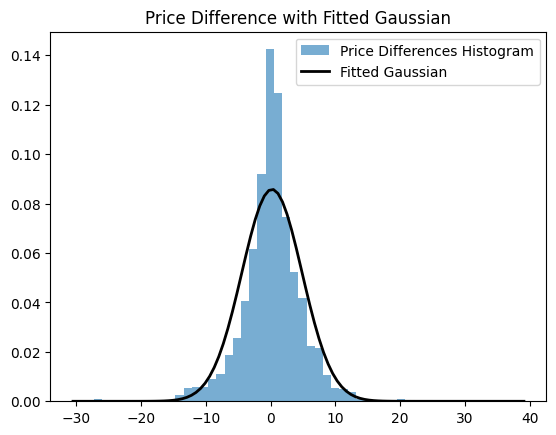

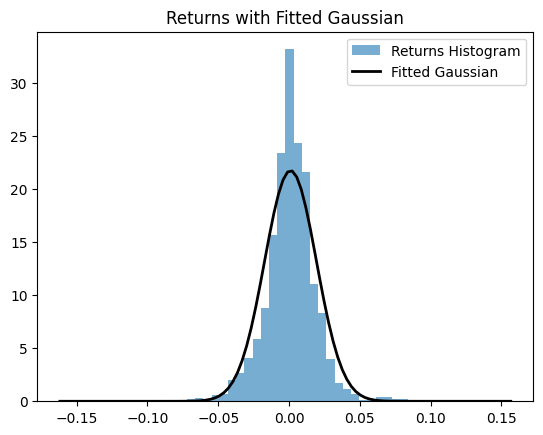

In [92]:
compare_gaussian(df)

#### Simulate Bachelier & Samuelson (One Path Each)

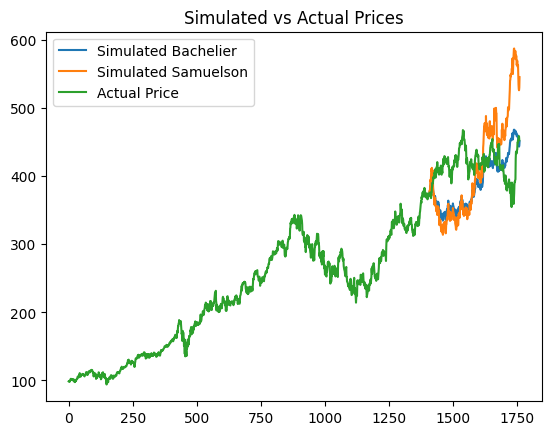

In [93]:
historical_data, future_data = data_split(df, test_size=0.2)
price_diffs, returns, mu_diff, std_diff, mu_ret, std_ret = fit_gaussian(historical_data)

# Start from the last price in the training set
start_price = historical_data['Last Closing Price'].iloc[-1]
days = len(future_data) 

sim_bachelier = simulate_price_path(start_price, mu_diff, std_diff, days, model='bachelier')
sim_samuelson = simulate_price_path(start_price, mu_ret, std_ret, days, model='samuelson')

plt.figure()
plt.plot(range(len(historical_data), len(df)+1), sim_bachelier, label='Simulated Bachelier')
plt.plot(range(len(historical_data), len(df)+1), sim_samuelson, label='Simulated Samuelson')
plt.plot(df['Last Closing Price'].values, label='Actual Price')
plt.title('Simulated vs Actual Prices')
plt.legend()
plt.show()

#### Simulate Bachelier & Samuelson (Multiple Paths Each)

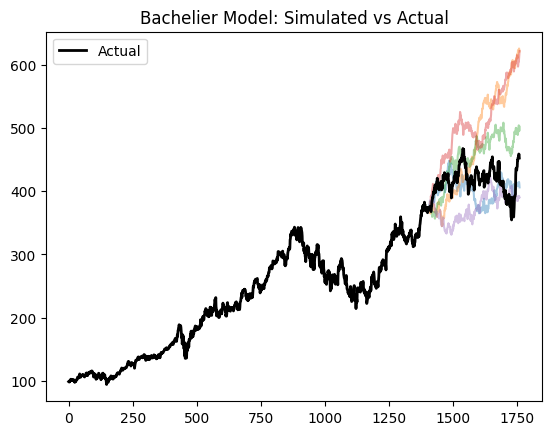

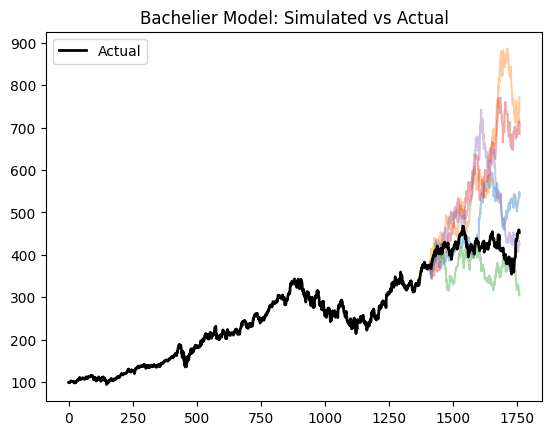

In [94]:
historical_data, future_data = data_split(df, test_size=0.2)
price_diffs, returns, mu_diff, std_diff, mu_ret, std_ret = fit_gaussian(historical_data)

start_price = historical_data['Last Closing Price'].iloc[-1]
days = len(future_data)
n_paths = 5 # Number of simulations per model

paths_bachelier = simulate_multiple_paths(start_price, mu_diff, std_diff, days, model='bachelier', n_paths=n_paths)
paths_samuelson = simulate_multiple_paths(start_price, mu_ret, std_ret, days, model='samuelson', n_paths=n_paths)

plot_multiple_paths(paths_bachelier, historical_data, df)
plot_multiple_paths(paths_samuelson, historical_data, df)

In [95]:
# Final prices of each simulated path
final_bachelier = paths_bachelier[:, -1]
final_samuelson = paths_samuelson[:, -1]
real_final = df['Last Closing Price'].iloc[-1]

print("=== Final Price Stats ===")
print(f"Actual final price: {real_final:.2f}")
print(f"Bachelier model(s): mean={final_bachelier.mean():.2f}, std={final_bachelier.std():.2f}") # mean & std of all paths
print(f"Samuelson model(s): mean={final_samuelson.mean():.2f}, std={final_samuelson.std():.2f}")

=== Final Price Stats ===
Actual final price: 452.57
Bachelier model(s): mean=508.27, std=100.12
Samuelson model(s): mean=544.55, std=169.34
